In [1]:
from waffles.data_classes.WaveformSet import *
from waffles.data_classes.Waveform import *
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
from pathlib import Path

from scipy.fft import fft, fftshift

In [2]:
def channel_filter(waveform : Waveform, end : int, ch : int) -> bool:
    if (waveform.channel == ch) and (waveform.endpoint == end) :
        return True
    else:
        return False
    
def beam_self_trigger_filter(waveform : Waveform, timeoffset_min : int = -120, timeoffset_max : int = -90) -> bool:
    daq_pds_timeoffset = waveform.timestamp - waveform.daq_window_timestamp
    if (daq_pds_timeoffset < timeoffset_max) and (daq_pds_timeoffset > timeoffset_min) :
        return True
    else:
        return False

def fbk_or_hpk(endpoint: int, channel: int):
    channel_vendor_map = {
    104: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "HPK", 11: "HPK", 12: "HPK", 13: "HPK", 14: "HPK", 15: "HPK", 16: "HPK", 17: "HPK"},
    105: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "FBK", 12: "FBK", 15: "FBK", 17: "FBK", 21: "HPK", 23: "HPK", 24: "HPK", 26: "HPK"},
    107: {0: "FBK", 2: "FBK", 5: "FBK", 7: "FBK",
          10: "HPK", 12: "HPK", 15: "HPK", 17: "HPK"},
    109: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "FBK", 11: "FBK", 12: "FBK", 13: "FBK", 14: "FBK", 15: "FBK", 16: "FBK", 17: "FBK",
          20: "HPK", 21: "HPK", 22: "HPK", 23: "HPK", 24: "HPK", 25: "HPK", 26: "HPK", 27: "HPK",
          30: "HPK", 31: "HPK", 32: "HPK", 33: "HPK", 34: "HPK", 35: "HPK", 36: "HPK", 37: "HPK",
          40: "HPK", 41: "HPK", 42: "HPK", 43: "HPK", 44: "HPK", 45: "HPK", 46: "HPK", 47: "HPK"},
    111: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "FBK", 11: "FBK", 12: "FBK", 13: "FBK", 14: "FBK", 15: "FBK", 16: "FBK", 17: "FBK",
          20: "FBK", 21: "FBK", 22: "FBK", 23: "FBK", 24: "FBK", 25: "FBK", 26: "FBK", 27: "FBK",
          30: "HPK", 31: "HPK", 32: "HPK", 33: "HPK", 34: "HPK", 35: "HPK", 36: "HPK", 37: "HPK",
          40: "HPK", 41: "HPK", 42: "HPK", 43: "HPK", 44: "HPK", 45: "HPK", 46: "HPK", 47: "HPK"},
    112: {0: "HPK", 1: "HPK", 2: "HPK", 3: "HPK", 4: "HPK", 5: "HPK", 6: "HPK", 7: "HPK",
          10: "HPK", 11: "HPK", 12: "HPK", 13: "HPK", 14: "HPK", 15: "HPK", 16: "HPK", 17: "HPK",
          20: "HPK", 21: "HPK", 22: "HPK", 23: "HPK", 24: "HPK", 25: "HPK", 26: "HPK", 27: "HPK",
          30: "HPK", 31: "HPK", 32: "HPK", 33: "HPK", 34: "HPK", 35: "HPK", 36: "HPK", 37: "HPK",
          40: "HPK", 42: "HPK", 45: "HPK", 47: "HPK"},
    113: {0: "FBK", 2: "FBK", 5: "FBK", 7: "FBK"}}

    return channel_vendor_map[endpoint][channel]

In [3]:
# CHANNEL SELECTION

apa = 2
endpoint = 109
daq_channel = 7
vendor = fbk_or_hpk(endpoint,daq_channel)
print(vendor)

FBK


Reading waveform pickles file...
done



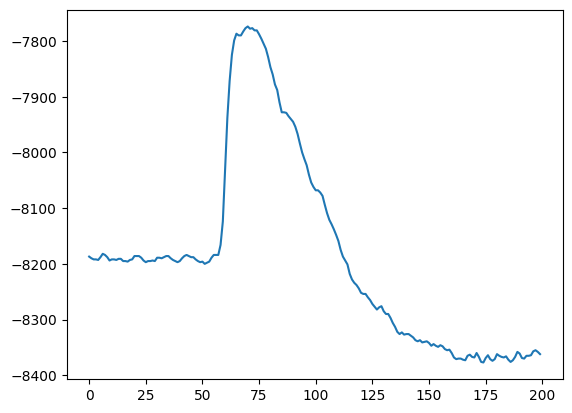

In [19]:
print('Reading waveform pickles file...')
with open(f"/afs/cern.ch/work/a/anbalbon/public/np04_beam_pickles/set_A/run_27355/self_0.pkl", 'rb') as f:
    wfset = pickle.load(f) 
    print('done\n')
    
my_wfset = WaveformSet.from_filtered_WaveformSet(WaveformSet.from_filtered_WaveformSet(wfset, beam_self_trigger_filter), channel_filter, end=endpoint, ch=daq_channel)


n_wf = 1
my_waveform = my_wfset.waveforms[n_wf]
time_ticks = np.arange(len(my_waveform.adcs)) + my_waveform.time_offset
waveform_adcs = -1 * my_waveform.adcs 

plt.plot(waveform_adcs[0:200])

8190.50985179228
True


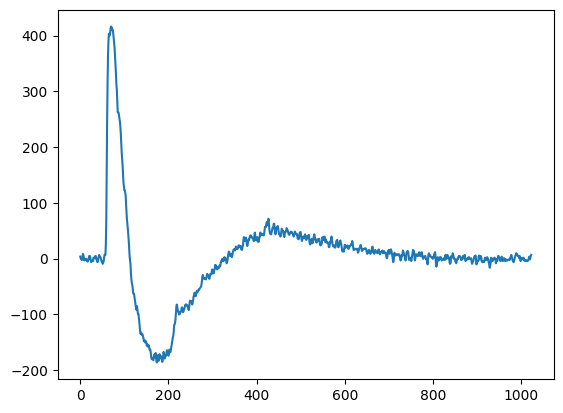

In [20]:
from waffles.utils.baseline.baseline import SBaseline



baseliner = SBaseline()
baseliner.binsbase       = np.linspace(0,2**14-1,2**14)
baseliner.threshold      = 6
baseliner.wait           = 25
baseliner.minimumfrac    = 0.166666
baseliner.baselinestart  = 0
baseliner.baselinefinish = 50 #112
#baseline_finish_response =  60 # togli

base, optimal = baseliner.wfset_baseline(my_waveform)

print(base)
print(optimal)

new_wf_adcs = my_waveform.adcs
new_wf_adcs = -( new_wf_adcs.astype(float) - base)

plt.plot(new_wf_adcs)



In [6]:
#filter
# w = np.ones(5)
# new_waveforms_adcs = np.convolve(waveform_adcs,w,"valid")
# plt.plot(new_waveforms_adcs[5:-5])

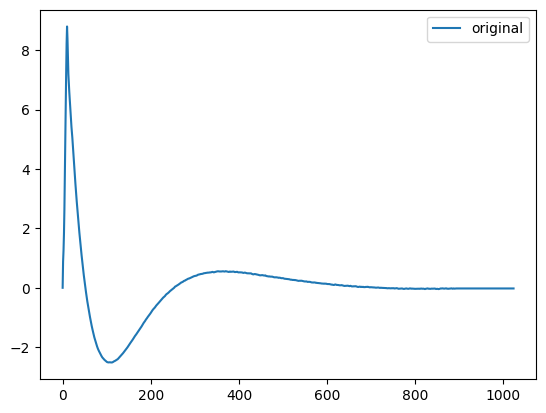

In [7]:
#MARITZA TEMPLATE

maritza_template_folder = '/afs/cern.ch/work/a/anbalbon/public/template_larsoft'

Larsoft_daphne_channel_map_path = '/afs/cern.ch/work/a/anbalbon/public/template_larsoft/PDHD_PDS_ChannelMap.csv' #By federico

df = pd.read_csv(Larsoft_daphne_channel_map_path, sep=",")
daphne_channels = df['daphne_ch'].values + 100*df['endpoint'].values
daphne_to_offline = dict(zip(daphne_channels, df['offline_ch']))
offline_to_daphne = dict(zip(df['offline_ch'],daphne_channels))

daphne_channel = daq_channel + 100*endpoint
apa_template_folder  = next((f for f in Path(maritza_template_folder).glob("*APA2*") if f.is_dir()), None)
if apa_template_folder:
    martiza_template_file = next(apa_template_folder.glob(f"*APA{apa}_CH{daphne_to_offline[daphne_channel]}*.txt"), None)
    if martiza_template_file:
        with open(martiza_template_file, "r") as file:
            maritza_values = [float(line.strip()) for line in file]
        roll_index=0
        maritza_template = np.array(maritza_values) 
        maritza_template=np.roll(maritza_template,roll_index)
        plt.plot(maritza_template,label='original')
        
        # #filter
        # wn=0.3
        # b,a = signal.butter(4, wn, btype='low', analog=False)
        # filtered_maritza_template = signal.filtfilt(b,a,maritza_template)
        # plt.plot(filtered_maritza_template[0:1024],label='filtered')
        
        plt.legend()
        
    else:
        print('File not found')
else:
    print("Cartella non trovata")


/afs/cern.ch/work/a/anbalbon/private/virtual_env/dbt_env/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/afs/cern.ch/work/a/anbalbon/private/virtual_env/dbt_env/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


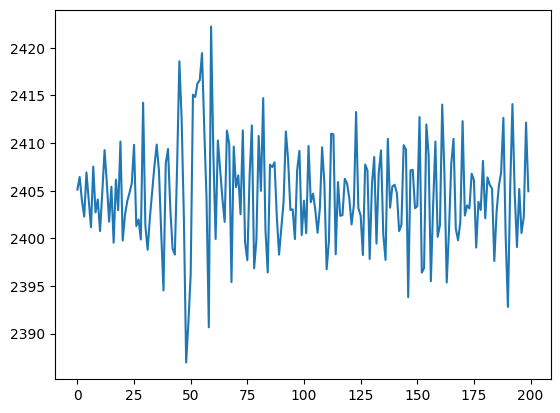

In [8]:
if martiza_template_file:
    signal_fft = np.fft.fft(waveform_adcs)
    
    martiza_template_menos_fft = np.fft.fft(maritza_template, n=len(waveform_adcs))  # Match signal length
    martiza_deconvolved_fft = signal_fft/ (martiza_template_menos_fft )     # Division in frequency domain
    martiza_deconvolved_aux = np.fft.ifft(martiza_deconvolved_fft)      # Transform back to time domain
    plt.plot(martiza_deconvolved_aux[0:200], label = 'original')

    # martiza_filtered_template_menos_fft = np.fft.fft(filtered_maritza_template, n=len(waveform_adcs))  # Match signal length
    # martiza_filtered_deconvolved_fft = signal_fft/ (martiza_filtered_template_menos_fft )     # Division in frequency domain
    # filtered_martiza_deconvolved_aux = np.fft.ifft(martiza_filtered_deconvolved_fft)      # Transform back to time domain
    # plt.plot(filtered_martiza_deconvolved_aux[0:200], label = 'filtered')


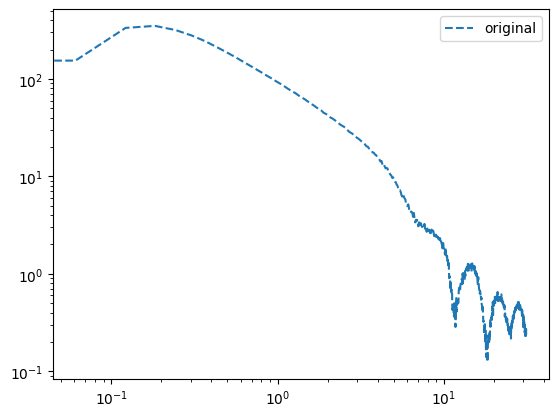

In [9]:

if martiza_template_file:
    frequencies = np.fft.fftfreq(1024, d=16*1e-9*1e+6)[:1024//2+1]
    frequencies[-1] = -frequencies[-1]
    plt.plot(frequencies,(np.abs(martiza_template_menos_fft))[0:int(1024/2+1)],linestyle="--", label='original')
    
    
    # martiza_filtered_template_menos_fft = np.fft.fft(filtered_maritza_template, n=len(waveform_adcs))  # Match signal length
    # plt.plot(frequencies,(np.abs(martiza_filtered_template_menos_fft))[0:int(1024/2+1)],linestyle="--",label='filtered')
    
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    


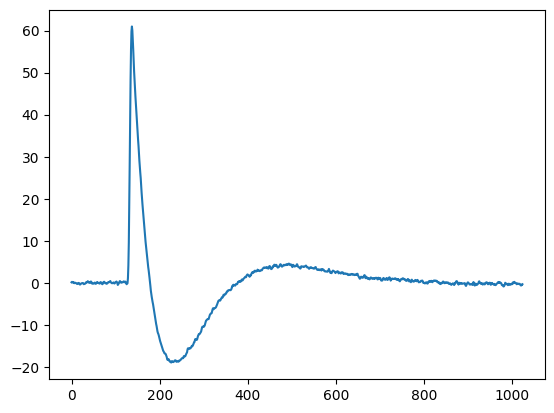

In [21]:
# OTHER TEMPLATES 

other_template = '/afs/cern.ch/work/a/anbalbon/private/waffles/src/waffles/np04_analysis/tau_slow_convolution/output/templates/template_run028489_ch10907_avg.pkl'

with open(other_template, 'rb') as f:
    wfset = pickle.load(f)

if len(other_template)>0:
    with open(f"{other_template}", "rb") as file:
        other_values = (pickle.load(file))[0]

    roll_index=0
    other_template = np.array(other_values) 
    other_template = np.roll(other_template,roll_index)
    plt.plot(other_template)

[ 4018.08823529    +0.j         -5281.61300481+11348.37950667j
 25062.88490754 +3348.95191819j ... 13572.27023031+20795.85382684j
 25062.88490754 -3348.95191819j -5281.61300481-11348.37950667j]


/afs/cern.ch/work/a/anbalbon/private/virtual_env/dbt_env/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/afs/cern.ch/work/a/anbalbon/private/virtual_env/dbt_env/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


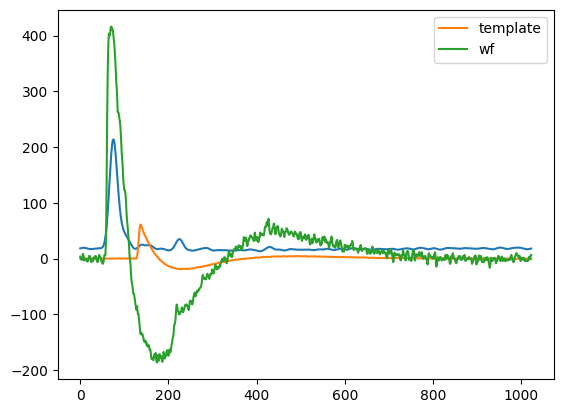

In [76]:
def gaus(x, sigma=20):
    return np.exp(-(x)**2/2/sigma**2)
_x = np.linspace(0, 1024, 1024, endpoint=False)
filter_gaus = [ gaus(x) for x in _x]


if len(other_template)>0:
    signal_fft = np.fft.fft(new_wf_adcs)
    other_template_menos_fft = np.fft.fft(other_template, n=len(other_template))  # Match signal length
    other_deconvolved_fft = signal_fft / (other_template_menos_fft)     # Division in frequency domain
    for j, _ in enumerate(other_deconvolved_fft):
        other_deconvolved_fft[j] *= filter_gaus[j]
    other_deconvolved_aux = np.fft.ifft(other_deconvolved_fft)      # Transform back to time domain
    
    # offset_of_template = get_offset(other_template)
    # offset_of_response = get_offset(new_wf_adcs)
    offset_of_template = 60
    offset_of_response = 145
    other_deconvolved_aux = np.roll(other_deconvolved_aux, offset_of_response)
    
    print(signal_fft)
    
    wf_prova = np.fft.ifft(signal_fft)
    
    template_prova = np.fft.ifft(other_template_menos_fft)
    
    plt.plot(other_deconvolved_aux*1000)
    plt.plot(template_prova, label='template') #blue
    plt.plot(wf_prova, label='wf') #orange
    #plt.xlim(0,150)
    plt.legend()

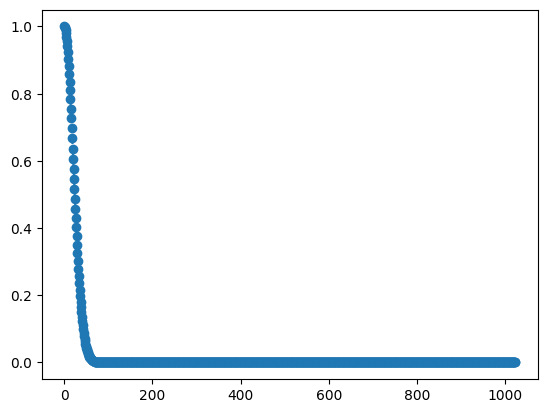

In [41]:
plt.plot(_x, filter_gaus, '--o')

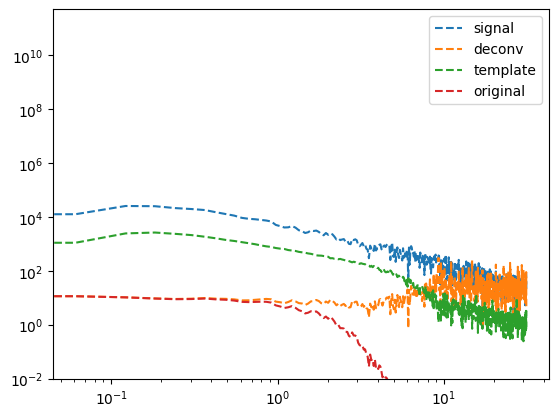

In [89]:

if len(other_template)>0:
   signal_fft = np.fft.fft(new_wf_adcs)
   fft_temp = np.fft.fft(other_template, n=len(other_template))  # Match signal length
   fft_rapporto = signal_fft / (fft_temp)     # Division in frequency domain
   rapporto_deconv = np.fft.ifft(fft_rapporto) 
   
   frequencies = np.fft.fftfreq(1024, d=16*1e-9*1e+6)[:1024//2+1]
   frequencies[-1] = -frequencies[-1]
   plt.plot(frequencies,(np.abs(signal_fft))[0:int(1024/2+1)],linestyle="--", label='signal')
   plt.plot(frequencies,(np.abs(fft_rapporto))[0:int(1024/2+1)],linestyle="--", label='deconv')
   plt.plot(frequencies,(np.abs(fft_temp))[0:int(1024/2+1)],linestyle="--", label='template')
   plt.plot(frequencies,(np.abs(other_deconvolved_fft))[0:int(1024/2+1)],linestyle="--", label='original')


   plt.yscale("log")
   plt.xscale("log")
   plt.ylim(1e-2,None)
   plt.legend() 